## Installing Required Libraries

In [ ]:
! pip install medcat

In [ ]:
# Get the scispacy model
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from medcat.cat import CAT
from medcat.cdb import CDB
from medcat.vocab import Vocab
from medcat.config import Config
from medcat.cdb_maker import CDBMaker

## Building Custom Vocab Model, Concept Database Model and MedCAT Pack

### Building Vocab

In [1]:
import pandas as pd
import string
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from transformers import BertModel, BertTokenizer
import torch
import csv

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mansipandya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
vocab_df = pd.read_csv("/Users/mansipandya/Desktop/KnidianMD/data/test_cases.csv")

In [3]:
vocab_df

,medical_history,symptoms
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm..."
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na..."
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '..."
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '..."
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea..."
5,A 24-year-old woman presents with acute swelli...,"{450: 'Range of joint movement reduced', 4216:..."
6,A 59-year-old man with a history of hypertensi...,"{3276: 'Chronic Onset', 9: 'Personal history o..."
7,"A 68-year-old woman with heart failure, chroni...","{104: 'Personal history heart failure', 9: 'Pe..."


In [4]:
sentences = vocab_df['medical_history'].tolist()

In [5]:
all_text = ' '.join(sentences)
clean_text = all_text.replace("-", " ")
print(clean_text)
words = word_tokenize(clean_text)
print(words)

A 24 year old woman presents with acute swelling in her right knee, pain that hinders her ability to bear weight on her right leg, and a one week history of intermittent low grade fevers and malaise. She has a history of daily heroin use but is otherwise healthy. She reports no recent sexual activity. On examination, her right knee is erythematous and hot, with an obvious joint effusion. She has limited and minimal range of motion of the knee. She has track marks over both antecubital fossae. Joint aspiration shows a leukocyte count of 132,000 cells per mm3 with 95% neutrophils. A 12 year old girl presents with sudden onset severe generalized abdominal pain associated with nausea, vomiting, and diarrhea. On exam she appears ill and has a temperature of 104°F (40°C). Her abdomen is tense with generalized tenderness and guarding. No bowel sounds are present. A 78 year old man with emphysema and a 65 pack year history of smoking reports progressive weakness during the past 3 months. The w

In [6]:
punctuations = set(string.punctuation)
words_without_punctuations = [word for word in words if word not in punctuations]
print(words_without_punctuations)

['A', '24', 'year', 'old', 'woman', 'presents', 'with', 'acute', 'swelling', 'in', 'her', 'right', 'knee', 'pain', 'that', 'hinders', 'her', 'ability', 'to', 'bear', 'weight', 'on', 'her', 'right', 'leg', 'and', 'a', 'one', 'week', 'history', 'of', 'intermittent', 'low', 'grade', 'fevers', 'and', 'malaise', 'She', 'has', 'a', 'history', 'of', 'daily', 'heroin', 'use', 'but', 'is', 'otherwise', 'healthy', 'She', 'reports', 'no', 'recent', 'sexual', 'activity', 'On', 'examination', 'her', 'right', 'knee', 'is', 'erythematous', 'and', 'hot', 'with', 'an', 'obvious', 'joint', 'effusion', 'She', 'has', 'limited', 'and', 'minimal', 'range', 'of', 'motion', 'of', 'the', 'knee', 'She', 'has', 'track', 'marks', 'over', 'both', 'antecubital', 'fossae', 'Joint', 'aspiration', 'shows', 'a', 'leukocyte', 'count', 'of', '132,000', 'cells', 'per', 'mm3', 'with', '95', 'neutrophils', 'A', '12', 'year', 'old', 'girl', 'presents', 'with', 'sudden', 'onset', 'severe', 'generalized', 'abdominal', 'pain', 

In [7]:
cleaned_words = [word.lower() for word in words_without_punctuations]
print(cleaned_words)

['a', '24', 'year', 'old', 'woman', 'presents', 'with', 'acute', 'swelling', 'in', 'her', 'right', 'knee', 'pain', 'that', 'hinders', 'her', 'ability', 'to', 'bear', 'weight', 'on', 'her', 'right', 'leg', 'and', 'a', 'one', 'week', 'history', 'of', 'intermittent', 'low', 'grade', 'fevers', 'and', 'malaise', 'she', 'has', 'a', 'history', 'of', 'daily', 'heroin', 'use', 'but', 'is', 'otherwise', 'healthy', 'she', 'reports', 'no', 'recent', 'sexual', 'activity', 'on', 'examination', 'her', 'right', 'knee', 'is', 'erythematous', 'and', 'hot', 'with', 'an', 'obvious', 'joint', 'effusion', 'she', 'has', 'limited', 'and', 'minimal', 'range', 'of', 'motion', 'of', 'the', 'knee', 'she', 'has', 'track', 'marks', 'over', 'both', 'antecubital', 'fossae', 'joint', 'aspiration', 'shows', 'a', 'leukocyte', 'count', 'of', '132,000', 'cells', 'per', 'mm3', 'with', '95', 'neutrophils', 'a', '12', 'year', 'old', 'girl', 'presents', 'with', 'sudden', 'onset', 'severe', 'generalized', 'abdominal', 'pain', 

In [8]:
# Count the frequency of each word
word_counts = Counter(cleaned_words)
word_counts_dict = dict(word_counts)
print(word_counts_dict)

{'a': 41, '24': 2, 'year': 9, 'old': 8, 'woman': 4, 'presents': 5, 'with': 23, 'acute': 2, 'swelling': 2, 'in': 6, 'her': 25, 'right': 7, 'knee': 6, 'pain': 7, 'that': 6, 'hinders': 2, 'ability': 2, 'to': 15, 'bear': 2, 'weight': 3, 'on': 12, 'leg': 2, 'and': 41, 'one': 3, 'week': 2, 'history': 7, 'of': 38, 'intermittent': 2, 'low': 2, 'grade': 2, 'fevers': 2, 'malaise': 2, 'she': 20, 'has': 15, 'daily': 2, 'heroin': 2, 'use': 3, 'but': 3, 'is': 33, 'otherwise': 4, 'healthy': 3, 'reports': 5, 'no': 7, 'recent': 3, 'sexual': 2, 'activity': 2, 'examination': 8, 'erythematous': 2, 'hot': 2, 'an': 7, 'obvious': 2, 'joint': 4, 'effusion': 2, 'limited': 2, 'minimal': 2, 'range': 4, 'motion': 2, 'the': 27, 'track': 2, 'marks': 2, 'over': 4, 'both': 4, 'antecubital': 2, 'fossae': 2, 'aspiration': 2, 'shows': 4, 'leukocyte': 4, 'count': 4, '132,000': 2, 'cells': 2, 'per': 8, 'mm3': 4, '95': 2, 'neutrophils': 2, '12': 2, 'girl': 2, 'sudden': 1, 'onset': 1, 'severe': 1, 'generalized': 2, 'abdomin

In [9]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

word_embeddings_dict = {}

for word in cleaned_words:
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids_tensor = torch.tensor([input_ids])
    with torch.no_grad():
        outputs = model(input_ids_tensor)
        word_embeddings = outputs.last_hidden_state
        word_embedding = word_embeddings[0][0].tolist()
        word_embeddings_dict[word] = word_embedding

In [10]:
vocab_path = '/Users/mansipandya/Desktop/KnidianMD/data/medcat/vocab.tsv'

with open(vocab_path, 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    for word, count in word_counts_dict.items():
        embedding = ' '.join(str(value) for value in word_embeddings_dict[word])
        writer.writerow([word, count, embedding])

In [13]:
vocab = Vocab()
vocab.add_words(vocab_path, replace=True)

In [14]:
# To see the words in the vocab
vocab.vocab.keys()

dict_keys(['a', '24', 'year', 'old', 'woman', 'presents', 'with', 'acute', 'swelling', 'in', 'her', 'right', 'knee', 'pain', 'that', 'hinders', 'ability', 'to', 'bear', 'weight', 'on', 'leg', 'and', 'one', 'week', 'history', 'of', 'intermittent', 'low', 'grade', 'fevers', 'malaise', 'she', 'has', 'daily', 'heroin', 'use', 'but', 'is', 'otherwise', 'healthy', 'reports', 'no', 'recent', 'sexual', 'activity', 'examination', 'erythematous', 'hot', 'an', 'obvious', 'joint', 'effusion', 'limited', 'minimal', 'range', 'motion', 'the', 'track', 'marks', 'over', 'both', 'antecubital', 'fossae', 'aspiration', 'shows', 'leukocyte', 'count', '132,000', 'cells', 'per', 'mm3', '95', 'neutrophils', '12', 'girl', 'sudden', 'onset', 'severe', 'generalized', 'abdominal', 'associated', 'nausea', 'vomiting', 'diarrhea', 'exam', 'appears', 'ill', 'temperature', '104°f', '40°c', 'abdomen', 'tense', 'tenderness', 'guarding', 'bowel', 'sounds', 'are', 'present', '78', 'man', 'emphysema', '65', 'pack', 'smokin

In [15]:
vocab.save('/Users/mansipandya/Desktop/KnidianMD/data/medcat/vocab.dat')

In [16]:
vocab = Vocab.load('/Users/mansipandya/Desktop/KnidianMD/data/medcat/vocab.dat')

### Building Concept Database (CDB)

In [ ]:
! python -m spacy download en_core_web_md

In [43]:
cdb_path = '/Users/mansipandya/Desktop/KnidianMD/data/medcat/medcat_cdb.csv'

In [44]:
cdb_df = pd.read_csv(cdb_path)

In [45]:
cdb_df

,cui,name
0,1,Family history of ankylosing spondylitis
1,2,tummy ache
2,2,hurt in belly
3,2,pain in belly
4,2,belly soreness
...,...,...
12060,4685,eeg normal
12061,4685,Electroencephalogram normal
12062,4685,EEG normal
12063,4685,Normal electroencephalogram


In [46]:
# First initialise the default configuration
config = Config()
config.general['spacy_model'] = 'en_core_web_md'
maker = CDBMaker(config)

In [47]:
cdb = maker.prepare_csvs([cdb_path], full_build=True)

In [48]:
# To display all names and cui in the db
print(cdb.name2cuis)

{'family~history~of~ankylosing~spondylitis': ['1'], 'tummy~ache': ['2'], 'hurt~in~belly': ['2'], 'pain~in~belly': ['2'], 'belly~soreness': ['2'], 'tummy~hurt': ['2'], 'tummy~discomfort': ['2'], 'stomach~soreness': ['2'], 'soreness~in~abdomen': ['2'], 'discomfort~in~tummy': ['2'], 'spasm~in~stomach': ['2'], 'ache~in~stomach': ['2'], 'discomfort~in~abdomen': ['2'], 'abdominal~irritation': ['2'], 'stomach~ache': ['2'], 'gut~pain': ['2'], 'abdominal~twinge': ['2'], 'ache~in~abdomen': ['2'], 'hurt~in~stomach': ['2'], 'stomach~hurt': ['2'], 'tummy~pain': ['2'], 'stomach~spasm': ['2'], 'pain~in~stomach': ['2'], 'hurt~in~abdomen': ['2'], 'soreness~in~stomach': ['2'], 'abdominal~spasm': ['2'], 'stomach~pain': ['2'], 'pain~in~tummy': ['2'], 'irritation~in~abdomen': ['2'], 'abdominal~soreness': ['2'], 'discomfort~in~stomach': ['2'], 'stomach~irritation': ['2'], 'abdominal~discomfort': ['2'], 'irritation~in~stomach': ['2'], 'abdominal~pain': ['2'], 'belly~irritation': ['2'], 'irritation~in~belly':

In [49]:
# To display all unique cuis and corresponding names in the db 
print(cdb.cui2names)

{'1': {'family~history~of~ankylosing~spondylitis'}, '2': {'painful~feeling~in~belly', 'soreness~in~abdomen', 'tummy~ache', 'discomfort~in~stomach', 'pain~in~tummy', 'abdominal~twinge', 'hurt~in~stomach', 'hurt~in~abdomen', 'belly~hurt', 'spasm~in~stomach', 'belly~irritation', 'pain~in~stomach', 'stomach~pain', 'irritation~in~belly', 'soreness~in~stomach', 'tummy~discomfort', 'irritation~in~stomach', 'pain~in~abdomen', 'abdominal~ache', 'tummy~pain', 'gut~pain', 'abdominal~soreness', 'irritation~in~abdomen', 'stomach~soreness', 'abdominal~spasm', 'ache~in~stomach', 'hurt~in~belly', 'stomach~discomfort', 'discomfort~in~abdomen', 'belly~soreness', 'ache~in~belly', 'stomach~spasm', 'pain~in~belly', 'stomach~irritation', 'ache~in~abdomen', 'abdominal~irritation', 'belly~ache', 'belly~discomfort', 'abdominal~discomfort', 'discomfort~in~tummy', 'tummy~hurt', 'stomach~hurt', 'abdominal~pain', 'stomach~ache'}, '3': {'backache~symptom', 'backache~symptoms', 'dorsodynia', 'back~over~pain', 'backs

In [39]:
cdb.save("/Users/mansipandya/Desktop/KnidianMD/data/medcat/cdb.dat")
cdb.config.save("/Users/mansipandya/Desktop/KnidianMD/data/medcat/cdb_config.json")

In [40]:
cdb = CDB.load("/Users/mansipandya/Desktop/KnidianMD/data/medcat/cdb.dat")
cdb.load_config("/Users/mansipandya/Desktop/KnidianMD/data/medcat/cdb_config.json")

### Setting up the CDB Configuration

In [22]:
cdb.config.ner['min_name_len'] = 2
cdb.config.ner['upper_case_limit_len'] = 3
cdb.config.general['spell_check'] = True
cdb.config.linking['train_count_threshold'] = 10
cdb.config.linking['similarity_threshold'] = 0.3
cdb.config.linking['train'] = True
cdb.config.linking['disamb_length_limit'] = 5
cdb.config.general['full_unlink'] = True

### Create a MedCAT model pack

In [23]:
# Initialise the model
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab)

In [33]:
cat.create_model_pack("/Users/mansipandya/Desktop/KnidianMD/data/medcat/medcat_modelpack")

'medcat_model_pack_97fe0f834daf8fc9'

## Unsupervised Learning

### Loading the MedCAT modelpack¶


In [34]:
cat = CAT.load_model_pack("/Users/mansipandya/Desktop/KnidianMD/data/medcat/medcat_modelpack/medcat_model_pack_97fe0f834daf8fc9.zip")

### Testing Named Entity Recognition + Linking (NER+L)¶


In [35]:
text = "A 24-year-old woman presents with acute swelling in her right knee, pain that hinders her ability to bear weight on her right leg, and a one-week history of intermittent low-grade fevers and malaise. She has a history of daily heroin use but is otherwise healthy. She reports no recent sexual activity. On examination, her right knee is erythematous and hot, with an obvious joint effusion. She has limited and minimal range of motion of the knee. She has track marks over both antecubital fossae. Joint aspiration shows a leukocyte count of 132,000 cells per mm3 with 95% neutrophils."
print(cat(text).ents)

(swelling, knee, pain, fevers, activity)


In [36]:
# To see all entities and corresponding meta-data
print(cat.get_entities(text, only_cui=False))

{'entities': {0: {'pretty_name': 'Finding Of Swelling Finding', 'cui': '4347', 'type_ids': [], 'types': [], 'source_value': 'swelling', 'detected_name': 'swelling', 'acc': 1.0, 'context_similarity': 1.0, 'start': 40, 'end': 48, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 0, 'meta_anns': {}}, 1: {'pretty_name': 'Arthralgia Of Knee Patella Tibia Fibula', 'cui': '1109', 'type_ids': [], 'types': [], 'source_value': 'knee, pain', 'detected_name': 'knee~pain', 'acc': 1.0, 'context_similarity': 1.0, 'start': 62, 'end': 72, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 1, 'meta_anns': {}}, 3: {'pretty_name': 'Body Temperature Above Reference Range', 'cui': '18', 'type_ids': [], 'types': [], 'source_value': 'fevers', 'detected_name': 'fever', 'acc': 1.0, 'context_similarity': 1.0, 'start': 180, 'end': 186, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 3, 'meta_anns': {}}, 4: {'pretty_name': 'Engaged In Physical Activity', 'cui': '4662', 'type_ids': [], 'types': [], 'source_valu

In [37]:
# If we want to see the CUI (ID) for each entity
for ent in cat(text).ents:
    print(ent, " - ", ent._.cui)

swelling  -  4347
knee, pain  -  1109
fevers  -  18
activity  -  4662


In [39]:
# We can also show the entities in a nicer way using displacy form spaCy
from spacy import displacy
displacy.render(cat(text), style='ent', jupyter=True)

### Load the Data

In [4]:
data = pd.read_csv("/Users/mansipandya/Desktop/KnidianMD/data/test_cases.csv")

In [5]:
data.head()

,medical_history,symptoms
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm..."
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na..."
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '..."
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '..."
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea..."


### Run unsupervised training

In [43]:
cat.cdb.print_stats()

In [44]:
cat.cdb.print_stats()
print()
print(f"There are {len(data['medical_history'])} documents to train...")

cat.train(data.medical_history.values, progress_print=100)

cat.cdb.print_stats()


There are 8 documents to train...


### Save the new MedCAT modelpack¶

In [46]:
# unsupervised trained model
model_pack_name = cat.create_model_pack("/Users/mansipandya/Desktop/KnidianMD/data/medcat/unsupervised_trained_model_pack")

### Annotate Documents

In [47]:
# Load the newly created MedCAT modelpack
model_pack_path_2 = "/Users/mansipandya/Desktop/KnidianMD/data/medcat/unsupervised_trained_model_pack/medcat_model_pack_4f146946af28d88d.zip"
cat = CAT.load_model_pack(model_pack_path_2)

In [48]:
text = "A 24-year-old woman presents with acute swelling in her right knee, pain that hinders her ability to bear weight on her right leg, and a one-week history of intermittent low-grade fevers and malaise. She has a history of daily heroin use but is otherwise healthy. She reports no recent sexual activity. On examination, her right knee is erythematous and hot, with an obvious joint effusion. She has limited and minimal range of motion of the knee. She has track marks over both antecubital fossae. Joint aspiration shows a leukocyte count of 132,000 cells per mm3 with 95% neutrophils."
annotated_text = cat.get_entities(text)

In [49]:
print(annotated_text)

{'entities': {0: {'pretty_name': 'Finding Of Swelling Finding', 'cui': '4347', 'type_ids': [], 'types': [], 'source_value': 'swelling', 'detected_name': 'swelling', 'acc': 1.0, 'context_similarity': 1.0, 'start': 40, 'end': 48, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 0, 'meta_anns': {}}, 1: {'pretty_name': 'Arthralgia Of Knee Patella Tibia Fibula', 'cui': '1109', 'type_ids': [], 'types': [], 'source_value': 'knee, pain', 'detected_name': 'knee~pain', 'acc': 1.0, 'context_similarity': 1.0, 'start': 62, 'end': 72, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 1, 'meta_anns': {}}, 3: {'pretty_name': 'Body Temperature Above Reference Range', 'cui': '18', 'type_ids': [], 'types': [], 'source_value': 'fevers', 'detected_name': 'fever', 'acc': 1.0, 'context_similarity': 1.0, 'start': 180, 'end': 186, 'icd10': [], 'ontologies': [], 'snomed': [], 'id': 3, 'meta_anns': {}}, 4: {'pretty_name': 'Engaged In Physical Activity', 'cui': '4662', 'type_ids': [], 'types': [], 'source_valu

Although we can annotate documents one by one, using the annotated_document = cat(text) option, but it will work much faster if we do it using the multi_processing method from medcat.

When using multi_processing medcat requires the following format for input documents:

in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
The output is (return from medcat):

out_data = [(doc_id, {'entities': [...], 'text': <...>), (doc_id, {'entities': [...], 'text': <...>}), ...]


In [50]:
data.shape

(8, 2)

In [51]:
in_data = []
for id, row in data[['medical_history']].iterrows():
    text = row['medical_history']
    in_data.append((id, text))

In [52]:
results = cat.multiprocessing_batch_char_size(in_data, batch_size_chars = 500000, nproc=8)

In [53]:
print(results)

{0: {'entities': {0: {'pretty_name': 'Finding Of Swelling Finding', 'cui': '4347', 'type_ids': [], 'types': [], 'source_value': 'swelling', 'detected_name': 'swelling', 'acc': 1.0, 'context_similarity': 1.0, 'start': 40, 'end': 48, 'id': 0, 'meta_anns': {}}, 1: {'pretty_name': 'Arthralgia Of Knee Patella Tibia Fibula', 'cui': '1109', 'type_ids': [], 'types': [], 'source_value': 'knee, pain', 'detected_name': 'knee~pain', 'acc': 1.0, 'context_similarity': 1.0, 'start': 62, 'end': 72, 'id': 1, 'meta_anns': {}}, 3: {'pretty_name': 'Body Temperature Above Reference Range', 'cui': '18', 'type_ids': [], 'types': [], 'source_value': 'fevers', 'detected_name': 'fever', 'acc': 1.0, 'context_similarity': 1.0, 'start': 180, 'end': 186, 'id': 3, 'meta_anns': {}}, 4: {'pretty_name': 'Engaged In Physical Activity', 'cui': '4662', 'type_ids': [], 'types': [], 'source_value': 'activity', 'detected_name': 'activity', 'acc': 1.0, 'context_similarity': 1.0, 'start': 293, 'end': 301, 'id': 4, 'meta_anns':

In [54]:
cui_list = []
for annotation in list(results[0]['entities'].values()):
    print(annotation['cui'], annotation['pretty_name'])
    print()

4347 Finding Of Swelling Finding

1109 Arthralgia Of Knee Patella Tibia Fibula

18 Body Temperature Above Reference Range

4662 Engaged In Physical Activity



Later we'll explore how we can boost the models performance even further through providing annotation labels created via the annotation tool: MedCATtrainer!

In [74]:
# To see all names in the concept db
print(cat.cdb.cui2names['18'])

{'hyperthermia', 'feverish', 'increased~body~temperature', 'febrile', 'temperature~elevation', 'pyrexia', 'temperature~raised', 'fevered', 'temperature~elevated', 'has~a~temperature', 'body~temperature~above~reference~range', 'hyperthermic', 'fever', 'high~body~temperature'}


In [65]:
# This will be a map from CUI to a list of documents where it appears: {"cui": [<doc_id>, <doc_id>, ...], ..}
cui_location = {}

In [66]:
# For the cui and thier corresponding documents
for doc in list(results.keys()):
    for annotation in list(results[doc]['entities'].values()):
        if annotation['cui'] in cui_location:
            cui_location[annotation['cui']].append(doc)
        else:
            cui_location[annotation['cui']] = [doc]

In [68]:
print(cui_location)

{'4347': [0, 5], '1109': [0, 5], '18': [0, 1, 3, 5], '4662': [0, 5], '4334': [1], '1047': [1], '1048': [1], '164': [1], '3772': [1], '110': [2, 2], '326': [2], '3729': [2], '37': [2], '4': [3, 3, 7], '1120': [3, 7], '1093': [3], '109': [3, 7], '4359': [3], '98': [3], '12': [3, 6, 7], '1871': [3], '4089': [3], '352': [4], '3732': [4], '1798': [4], '3775': [4], '167': [4], '671': [4], '9': [6], '125': [6], '3325': [6], '3466': [7], '19': [7], '429': [7], '811': [7]}


### Visualise the annotation frequency

In [139]:
data

,medical_history,symptoms
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm..."
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na..."
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '..."
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '..."
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea..."
5,A 24-year-old woman presents with acute swelli...,"{450: 'Range of joint movement reduced', 4216:..."
6,A 59-year-old man with a history of hypertensi...,"{3276: 'Chronic Onset', 9: 'Personal history o..."
7,"A 68-year-old woman with heart failure, chroni...","{104: 'Personal history heart failure', 9: 'Pe..."


In [6]:
data['subject_id'] = range(1, len(data) + 1)

In [7]:
data

,medical_history,symptoms,subject_id
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm...",1
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na...",2
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '...",3
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '...",4
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea...",5
5,A 24-year-old woman presents with acute swelli...,"{450: 'Range of joint movement reduced', 4216:...",6
6,A 59-year-old man with a history of hypertensi...,"{3276: 'Chronic Onset', 9: 'Personal history o...",7
7,"A 68-year-old woman with heart failure, chroni...","{104: 'Personal history heart failure', 9: 'Pe...",8


In [96]:
# We are going to count the number of subjects (patients) for each CUI
cui_subjects = {}
cui_subjects_unique = {}
for cui in cui_location:
    for location in cui_location[cui]:
        subject_id = data.iat[location, list(data.columns).index('subject_id')]
        if cui in cui_subjects:
            cui_subjects[cui].append(subject_id)
            cui_subjects_unique[cui].add(subject_id)
        else:
            cui_subjects[cui] = [subject_id]
            cui_subjects_unique[cui] = {subject_id}

In [101]:
cui_nsubjects = [('cui', 'nsubjects')]
for cui in cui_subjects_unique.keys():
    cui_nsubjects.append((cui, len(cui_subjects_unique[cui])))
df_cui_nsubjects = pd.DataFrame(cui_nsubjects[1:], columns=cui_nsubjects[0])

In [118]:
df_cui_nsubjects = df_cui_nsubjects.sort_values('nsubjects', ascending=False)

# Add name for each CUI
df_cui_nsubjects['name'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    name = list(cat.cdb.cui2names[cui])[0]
    df_cui_nsubjects.iat[i, cols.index('name')] = name


# Add the percentage column
total_subjects = len(data['subject_id'].unique())
df_cui_nsubjects['perc_subjects'] = (df_cui_nsubjects['nsubjects'] / total_subjects) * 100

df_cui_nsubjects.reset_index(drop=True, inplace=True)

In [119]:
df_cui_nsubjects.head()

,cui,nsubjects,name,perc_subjects
0,18,4,hyperthermia,50.0
1,12,3,dropsy,37.5
2,4347,2,swells,25.0
3,4662,2,motor~activity,25.0
4,1109,2,pain~in~the~knee,25.0


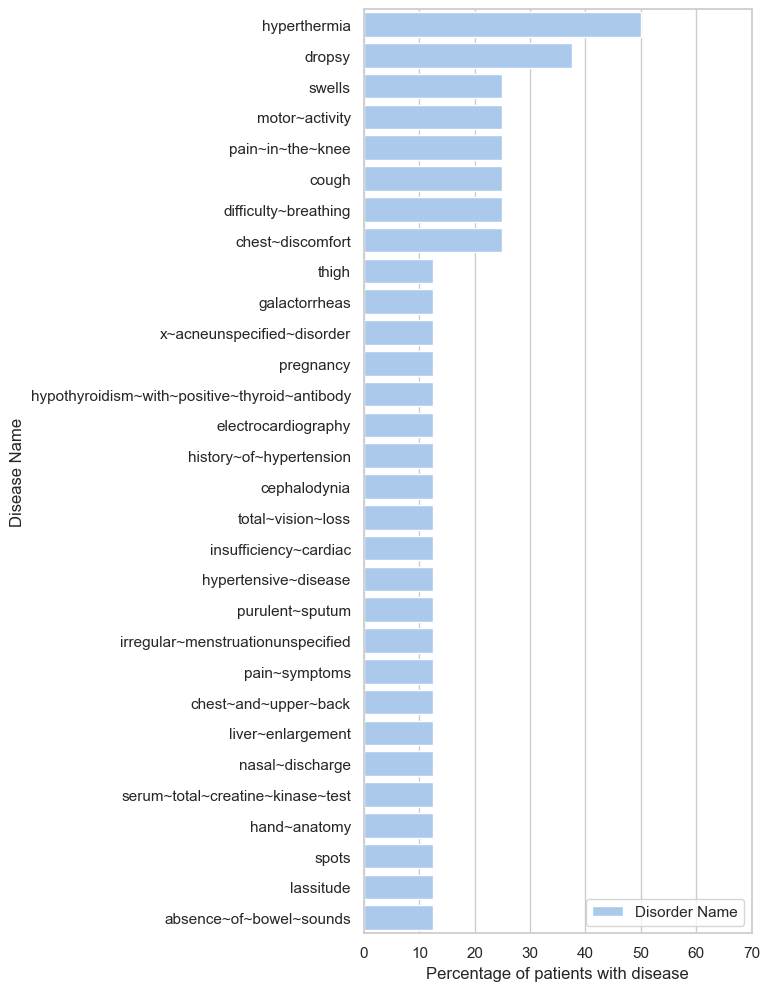

In [120]:
# Plot the top 30 diseases
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(5,12)}, 
    style="whitegrid",
    palette='pastel'
)
f, ax = plt.subplots()
_data = df_cui_nsubjects.iloc[0:30]
sns.barplot(x="perc_subjects", y="name", data=_data, label="Disorder Name", color="b")
_ = ax.set(xlim=(0, 70), ylabel="Disease Name", xlabel="Percentage of patients with disease")
plt.show()

## Supervised Training (MedCATtrainer)

### Preparing data for supervised training (MedCATtrainer)

As we want to do some fine-tuning on the models and also some meta-annotations (e.g. Status and Temporality), we'll take the top 100 CUIs from each TUI and for each take 2 examples.  (2x100x2 = 400 data points)

We'll do this because randomly choosing documents will give us only (most likely) the concepts on the very top by frequency (especially when there is a large drop between the top concepts).

The required output format for supervised training via MedCATtrainer is CSV with columns=(name, text)

In [121]:
df_cui_nsubjects.head()

,cui,nsubjects,name,perc_subjects
0,18,4,hyperthermia,50.0
1,12,3,dropsy,37.5
2,4347,2,swells,25.0
3,4662,2,motor~activity,25.0
4,1109,2,pain~in~the~knee,25.0


In [11]:
data

,medical_history,symptoms,subject_id
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm...",1
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na...",2
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '...",3
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '...",4
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea...",5
5,A 24-year-old woman presents with acute swelli...,"{450: 'Range of joint movement reduced', 4216:...",6
6,A 59-year-old man with a history of hypertensi...,"{3276: 'Chronic Onset', 9: 'Personal history o...",7
7,"A 68-year-old woman with heart failure, chroni...","{104: 'Personal history heart failure', 9: 'Pe...",8


In [12]:
train_data = data.copy()

In [13]:
train_data = train_data.rename(columns={'subject_id': "name"})
train_data = train_data.rename(columns={'medical_history': "text"})
train_data = train_data[['name', 'text']]
train_data.reset_index(drop=True, inplace=True)
train_data.head()

,name,text
0,1,A 24-year-old woman presents with acute swelli...
1,2,A 12-year-old girl presents with sudden-onset ...
2,3,A 78-year-old man with emphysema and a 65-pack...
3,4,A previously healthy 15-year-old girl presents...
4,5,A 19-year-old woman reports irregular menses. ...


In [14]:
train_data.to_csv("/Users/mansipandya/Desktop/KnidianMD/data/train_data.csv")

Use dock-compose up inside the MedCATtrainer folder to load the django application on docker.

once that's done all you have to do is run it. 

username : mansipandya29
password : Priyal$1309

we load the cdb.dat and vocab.dat into a new project annotate entity. Refer to this link -> https://medcattrainer.readthedocs.io/en/latest/project_admin.html

once the manual annotations are done you can downlaod it into a json format


### MedCATtrainer Export

In [41]:
import json

In [42]:
medcat_json_data = json.load(open("/Users/mansipandya/Desktop/KnidianMD/data/medcat/MedCAT_Annotated.json"))

In [43]:
medcat_json_data.keys()

dict_keys(['projects'])

In [44]:
medcat_json_data['projects'][0]['documents'][0].keys()

dict_keys(['id', 'name', 'text', 'last_modified', 'annotations', 'relations'])

In [45]:
medcat_json_data['projects'][0]['documents'][0]['annotations'][0].keys()

dict_keys(['id', 'user', 'cui', 'value', 'start', 'end', 'validated', 'correct', 'deleted', 'alternative', 'killed', 'irrelevant', 'create_time', 'last_modified', 'comment', 'manually_created', 'acc', 'meta_anns'])

In [47]:
# don't have meta-annotations yet
medcat_json_data['projects'][0]['documents'][0]['annotations'][0]['meta_anns'].keys()

dict_keys([])

### Fine-tuning the NER+L model

In [51]:
model_pack_path_2 = "/Users/mansipandya/Desktop/KnidianMD/data/medcat/unsupervised_trained_model_pack/medcat_model_pack_4f146946af28d88d.zip"
cat = CAT.load_model_pack(model_pack_path_2)

In [56]:
cat.train_supervised_from_json(data_path = "/Users/mansipandya/Desktop/KnidianMD/data/medcat/MedCAT_Annotated.json", 
                     nepochs=1,
                     reset_cui_count=False,
                     print_stats=True, 
                     use_filters=True) 

Epoch: 0, Prec: 0.961038961038961, Rec: 0.9487179487179487, F1: 0.9548387096774195

Docs with false positives: 1; 6

Docs with false negatives: 1; 8; 6



False Positives

acute~onset~within~21~days                                             - 3242                 -          1
decreased~motion~range                                                 - 450                  -          1
febrile                                                                - 18                   -          1


False Negatives

decreased~motion~range                                                 - 450                  -          1
joint~heat                                                             - 4216                 -          1
febrile                                                                - 18                   -          1
low~platelets                                                          - 2146                 -          1


True Positives

febrile                                   

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Project:   0%|          | 0/1 [00:00<?, ?it/s]

Document:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1, Prec: 0.961038961038961, Rec: 0.9487179487179487, F1: 0.9548387096774195

Docs with false positives: 1; 6

Docs with false negatives: 1; 8; 6



False Positives

acute~onset~within~21~days                                             - 3242                 -          1
decreased~motion~range                                                 - 450                  -          1
febrile                                                                - 18                   -          1


False Negatives

decreased~motion~range                                                 - 450                  -          1
joint~heat                                                             - 4216                 -          1
febrile                                                                - 18                   -          1
low~platelets                                                          - 2146                 -          1


True Positives

febrile                                   

({'3242': 1, '450': 1, '18': 1},
 {'450': 1, '4216': 1, '18': 1, '2146': 1},
 {'4347': 2,
  '1109': 2,
  '18': 3,
  '50': 2,
  '1469': 2,
  '4662': 2,
  '4226': 2,
  '33': 3,
  '4334': 1,
  '1047': 1,
  '1048': 1,
  '164': 1,
  '3779': 1,
  '15': 1,
  '3772': 1,
  '1225': 1,
  '110': 2,
  '160': 1,
  '1394': 1,
  '326': 1,
  '130': 1,
  '316': 3,
  '3242': 2,
  '4': 3,
  '1120': 2,
  '1093': 1,
  '109': 2,
  '78': 1,
  '4547': 2,
  '1165': 1,
  '4359': 1,
  '1167': 1,
  '352': 1,
  '166': 1,
  '1798': 1,
  '184': 1,
  '450': 1,
  '9': 1,
  '106': 1,
  '125': 1,
  '1228': 1,
  '2481': 1,
  '206': 1,
  '3994': 2,
  '4318': 1,
  '3466': 1,
  '19': 1,
  '2591': 1,
  '468': 1,
  '1887': 1,
  '146': 1,
  '155': 1,
  '811': 1,
  '4211': 1},
 {'18': 0.75,
  '33': 1.0,
  '316': 1.0,
  '4': 1.0,
  '4347': 1.0,
  '1109': 1.0,
  '50': 1.0,
  '1469': 1.0,
  '4662': 1.0,
  '4226': 1.0,
  '110': 1.0,
  '3242': 0.6666666666666666,
  '1120': 1.0,
  '109': 1.0,
  '4547': 1.0,
  '3994': 1.0,
  '4334': 1.

### Test of the whole pipeline

In [60]:
text = "A 19-year-old woman reports irregular menses. She reached menarche at age 12 and has typically had a menstrual period every 60 to 70 days since then, with each one lasting approximately 5 days. It has now been 3 months since her last period. She is not sexually active and has had no galactorrhea. She feels well, exercises regularly, and does not report any recent changes in weight. Her vital signs are normal, and her BMI is 21.5. Inflammatory acne is evident on her face and back, and a few terminal hairs are evident on the thighs and on the abdominal midline below the umbilicus. The thyroid gland is not enlarged. Abdominal and external genital examinations are normal. The patient's mother developed Hashimoto thyroiditis at a young age. A urine pregnancy test is negative."
doc = cat(text)

In [76]:
for i in range(len(cat.get_entities(text)['entities'])):
    each = cat.get_entities(text)['entities'][i]
    print("Entity: ", each['source_value'])
    print("Symptom :", each['pretty_name'])
    print("Cui:", each['cui'] )
    print("\n")

Entity:  irregular menses
Symptom : Irregular Menstrual Cycle Intervals
Cui: 352


Entity:  menstrual period every 60 to 70 days
Symptom : Time Between Periods Has Increased Symptom
Cui: 166


Entity:  galactorrhea
Symptom : Galactorrheas
Cui: 3732


Entity:  acne
Symptom : X Acneunspecified Disorder
Cui: 1798


Entity:  few terminal hairs
Symptom : Excessive Facial Or Body Hair
Cui: 184


Entity:  thighs
Symptom : Proximal Segment Of Free Lower Limb
Cui: 3775


Entity:  thyroiditis
Symptom : Hypothyroidism With Positive Thyroid Antibodies
Cui: 167


Entity:  pregnancy
Symptom : Pregnancy
Cui: 671




In [77]:
cat.create_model_pack("/Users/mansipandya/Desktop/KnidianMD/data/medcat/medcat_trained")

'medcat_model_pack_db2b2af3234d151a'

## Testing Model on Test Data

### Preprocessing the Input

In [78]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [79]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('no')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mansipandya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [178]:
df = pd.read_csv('/Users/mansipandya/Desktop/KnidianMD/data/test_cases.csv')

In [179]:
df

,medical_history,symptoms
0,A 24-year-old woman presents with acute swelli...,"{1276: 'joint swelling', 2438: 'fever', 50: 'm..."
1,A 12-year-old girl presents with sudden-onset ...,"{4334: 'Generalized abdominal pain', 1047: 'Na..."
2,A 78-year-old man with emphysema and a 65-pack...,"{1225: 'Personal history of emphysema', 110: '..."
3,A previously healthy 15-year-old girl presents...,"{3242: 'Acute Onset', 4: 'Chest pain', 1120: '..."
4,A 19-year-old woman reports irregular menses. ...,"{352: 'Irregular Menses', 166: 'Oligomenorrhea..."
5,A 24-year-old woman presents with acute swelli...,"{450: 'Range of joint movement reduced', 4216:..."
6,A 59-year-old man with a history of hypertensi...,"{3276: 'Chronic Onset', 9: 'Personal history o..."
7,"A 68-year-old woman with heart failure, chroni...","{104: 'Personal history heart failure', 9: 'Pe..."


### Defining the function

In [180]:
def medcat(document):
    symptom_dict = dict()
    cat = CAT.load_model_pack("/Users/mansipandya/Desktop/KnidianMD/data/medcat/medcat_trained/medcat_model_pack_db2b2af3234d151a.zip")
    for i in range(len(cat.get_entities(document)['entities'])):
        if i not in cat.get_entities(document)['entities']:
            continue
        each = cat.get_entities(document)['entities'][i]
        symptom_dict[int(each['cui'])] = each['pretty_name']
    return symptom_dict

In [193]:
text = "Patient is having irregular periods and lower stomach pain. There is a decrease in appetite and nausea."
symptom_dict = medcat(text)

In [194]:
symptom_dict

{352: 'Irregular Menstrual Cycle Intervals', 2: 'Painful Feeling In Belly'}